In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/denoising-dirty-documents/train.zip
/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip
/kaggle/input/denoising-dirty-documents/train_cleaned.zip
/kaggle/input/denoising-dirty-documents/test.zip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile, os, cv2
from tqdm.auto import tqdm

import imgaug as ia
from imgaug import augmenters as iaa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

sns.set_style('darkgrid')

# Data Prepation


In [3]:
path_zip = '../input/denoising-dirty-documents/'
path = '/kaggle/working/'

with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
    
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [4]:
imgs = [cv2.imread(path + 'train/' + f) for f in sorted(os.listdir(path + 'train/'))]
print('Median Dimensions:', np.median([len(img) for img in imgs]), np.median([len(img[0]) for img in imgs]))
del imgs

Median Dimensions: 420.0 540.0


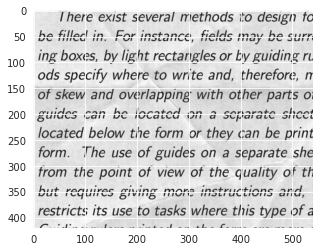

In [12]:
import matplotlib.pyplot as plt
imgs = [cv2.imread(path + 'train/' + f) for f in sorted(os.listdir(path + 'train/'))]
imgplot = plt.imshow(imgs[0])


In [5]:
 class DataLoader_Class:
    def __init__(self, path_zip , path):
        self.path_zip      = path_zip
        self.path          = path
        self.train_images  = []        
        self.train_cleaned = []
        self.test_images   = []
    def read_all_image(self):
        self.train_images_path  = [(self.path + 'train/' + f) for f in sorted(os.listdir(self.path + 'train/'))]
        self.train_cleaned_path = [(self.path + 'train_cleaned/' + f) for f in sorted(os.listdir(self.path + 'train_cleaned/'))]
        self.test_images_path   = [(self.path + 'test/' + f) for f in sorted(os.listdir(self.path + 'test/'))]
        
        transform = transforms.Compose([
            transforms.ToTensor()            
        ])
        
        for path in self.train_images_path:
            img = cv2.imread(path)
            img = np.asarray(img, dtype="uint8")
            img = cv2.resize(img, (540, 420) ,interpolation = cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = transform(transforms.ToPILImage()(img))
                
            self.train_images.append(img)
        
        for path in self.train_cleaned_path:
            img = cv2.imread(path)
            img = np.asarray(img, dtype="uint8")
            img = cv2.resize(img, (540, 420) ,interpolation = cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = transform(transforms.ToPILImage()(img))

            self.train_cleaned.append(img)
        
        for path in self.test_images_path:
            img = cv2.imread(path)
            img = np.asarray(img, dtype="uint8")
            img = cv2.resize(img, (540, 420) ,interpolation = cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = transform(transforms.ToPILImage()(img))

            self.test_images.append(img)
        
        #convert data list to tensor 
        self.train_images = torch.stack(self.train_images)
        self.train_cleaned = torch.stack(self.train_cleaned)
        self.test_images = torch.stack(self.test_images)

        print(self.train_images.shape)
        print(self.train_cleaned.shape)
        print(self.test_images.shape)
        
        return self.train_images, self.train_cleaned, self.test_images 
        
    def see_an_image(self, number):
        f, axarr = plt.subplots(1,2, figsize=(50,100))
        axarr[0].imshow(self.train_images[number].permute(1,2,0))
        axarr[1].imshow(self.train_cleaned[number].permute(1,2,0))



In [6]:
data_loader = DataLoader_Class(path_zip, path)
train_set_x, train_set_y , test_set_x = data_loader.read_all_image()

torch.Size([144, 3, 420, 540])
torch.Size([144, 3, 420, 540])
torch.Size([72, 3, 420, 540])


In [8]:
from random import randint

index = set(randint(0, 144) for p in range(0, 32))
index = list(index)

train_test_x = train_set_x[index]
train_test_y = train_set_y[index]

train_test_x.shape

torch.Size([26, 3, 420, 540])

torch.Size([144, 3, 420, 540])
torch.Size([144, 3, 420, 540])
torch.Size([72, 3, 420, 540])


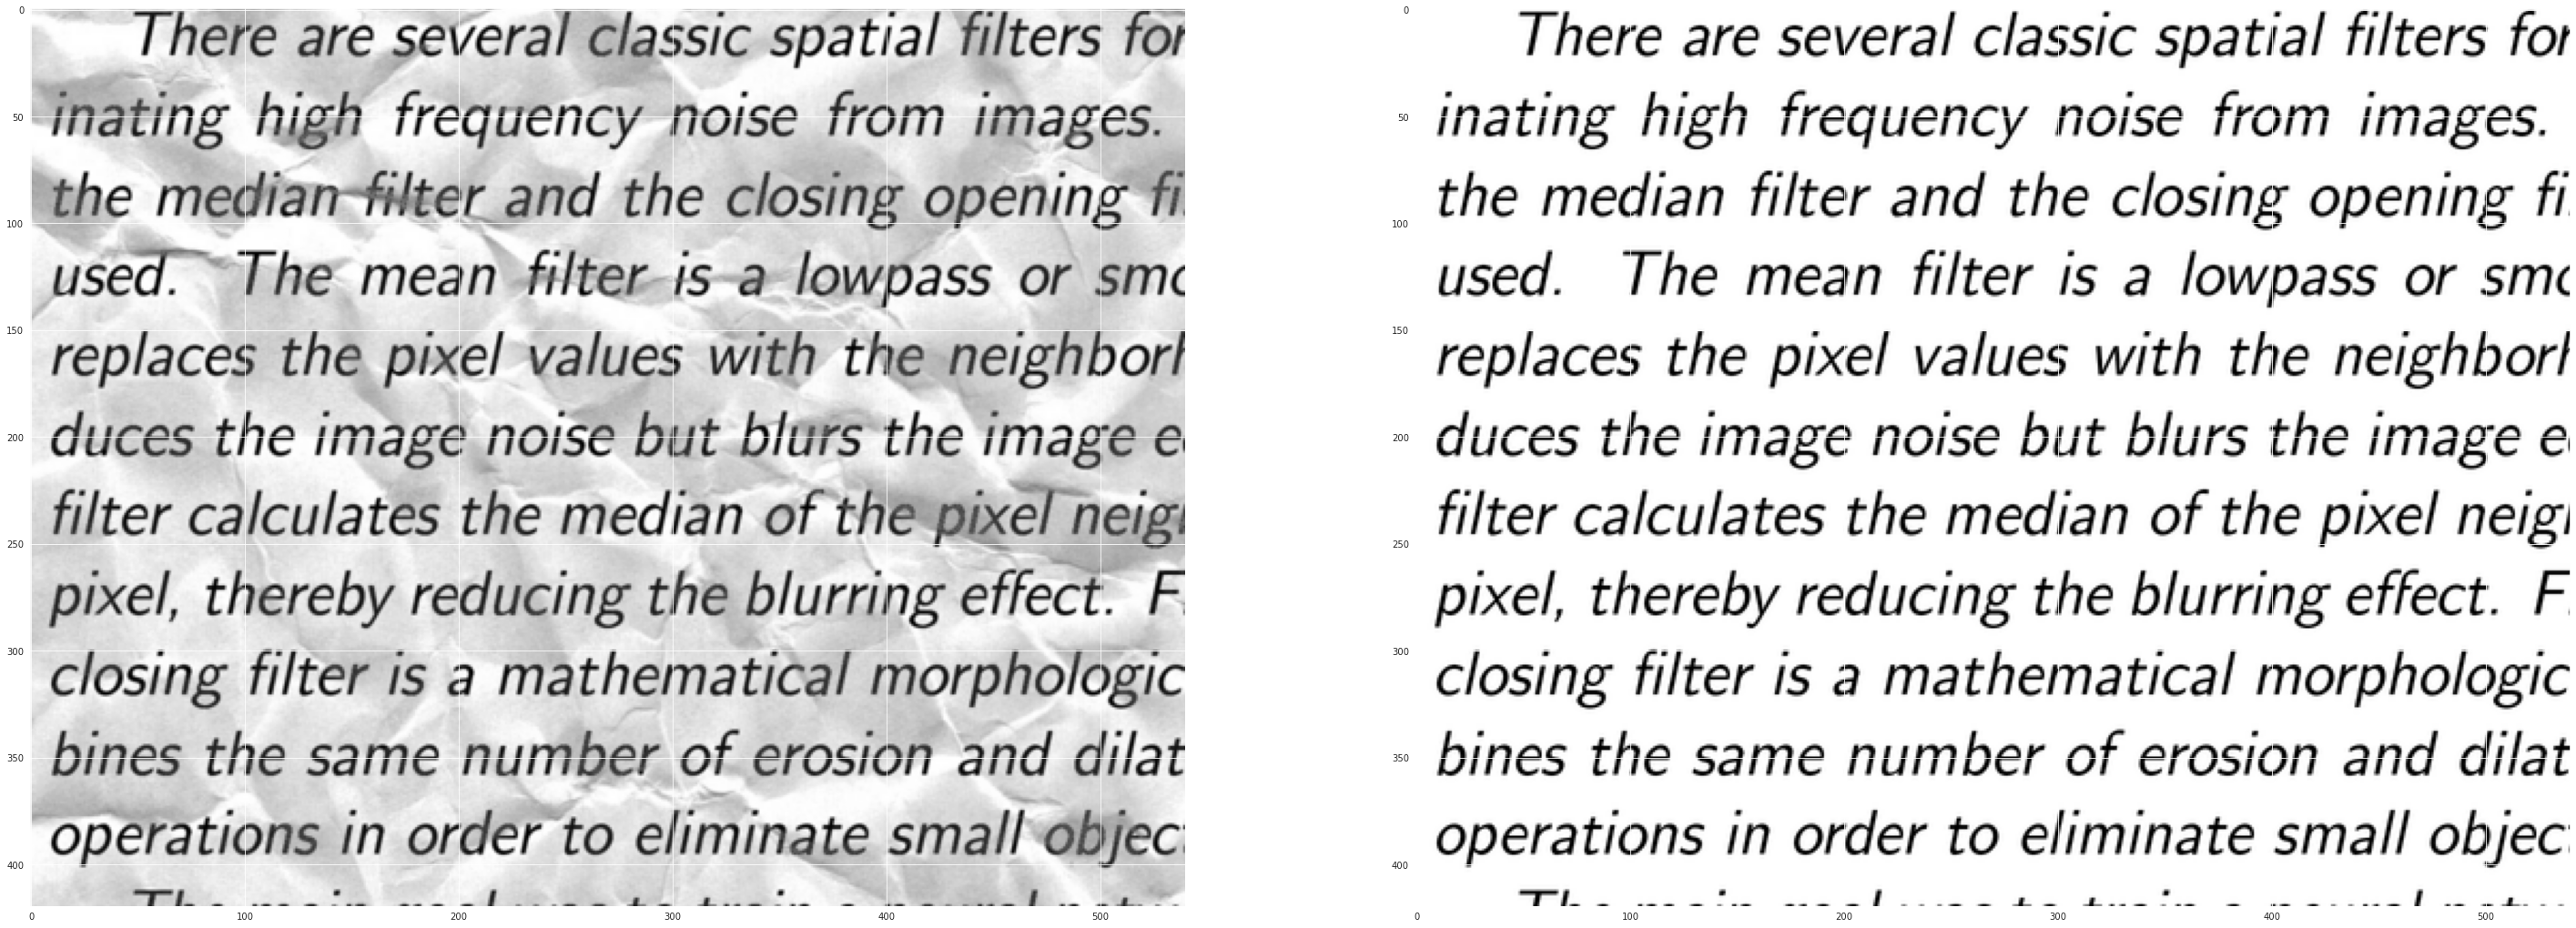

In [10]:
a = DataLoader_Class(path_zip, path)
b = a.read_all_image()
a.see_an_image(5)

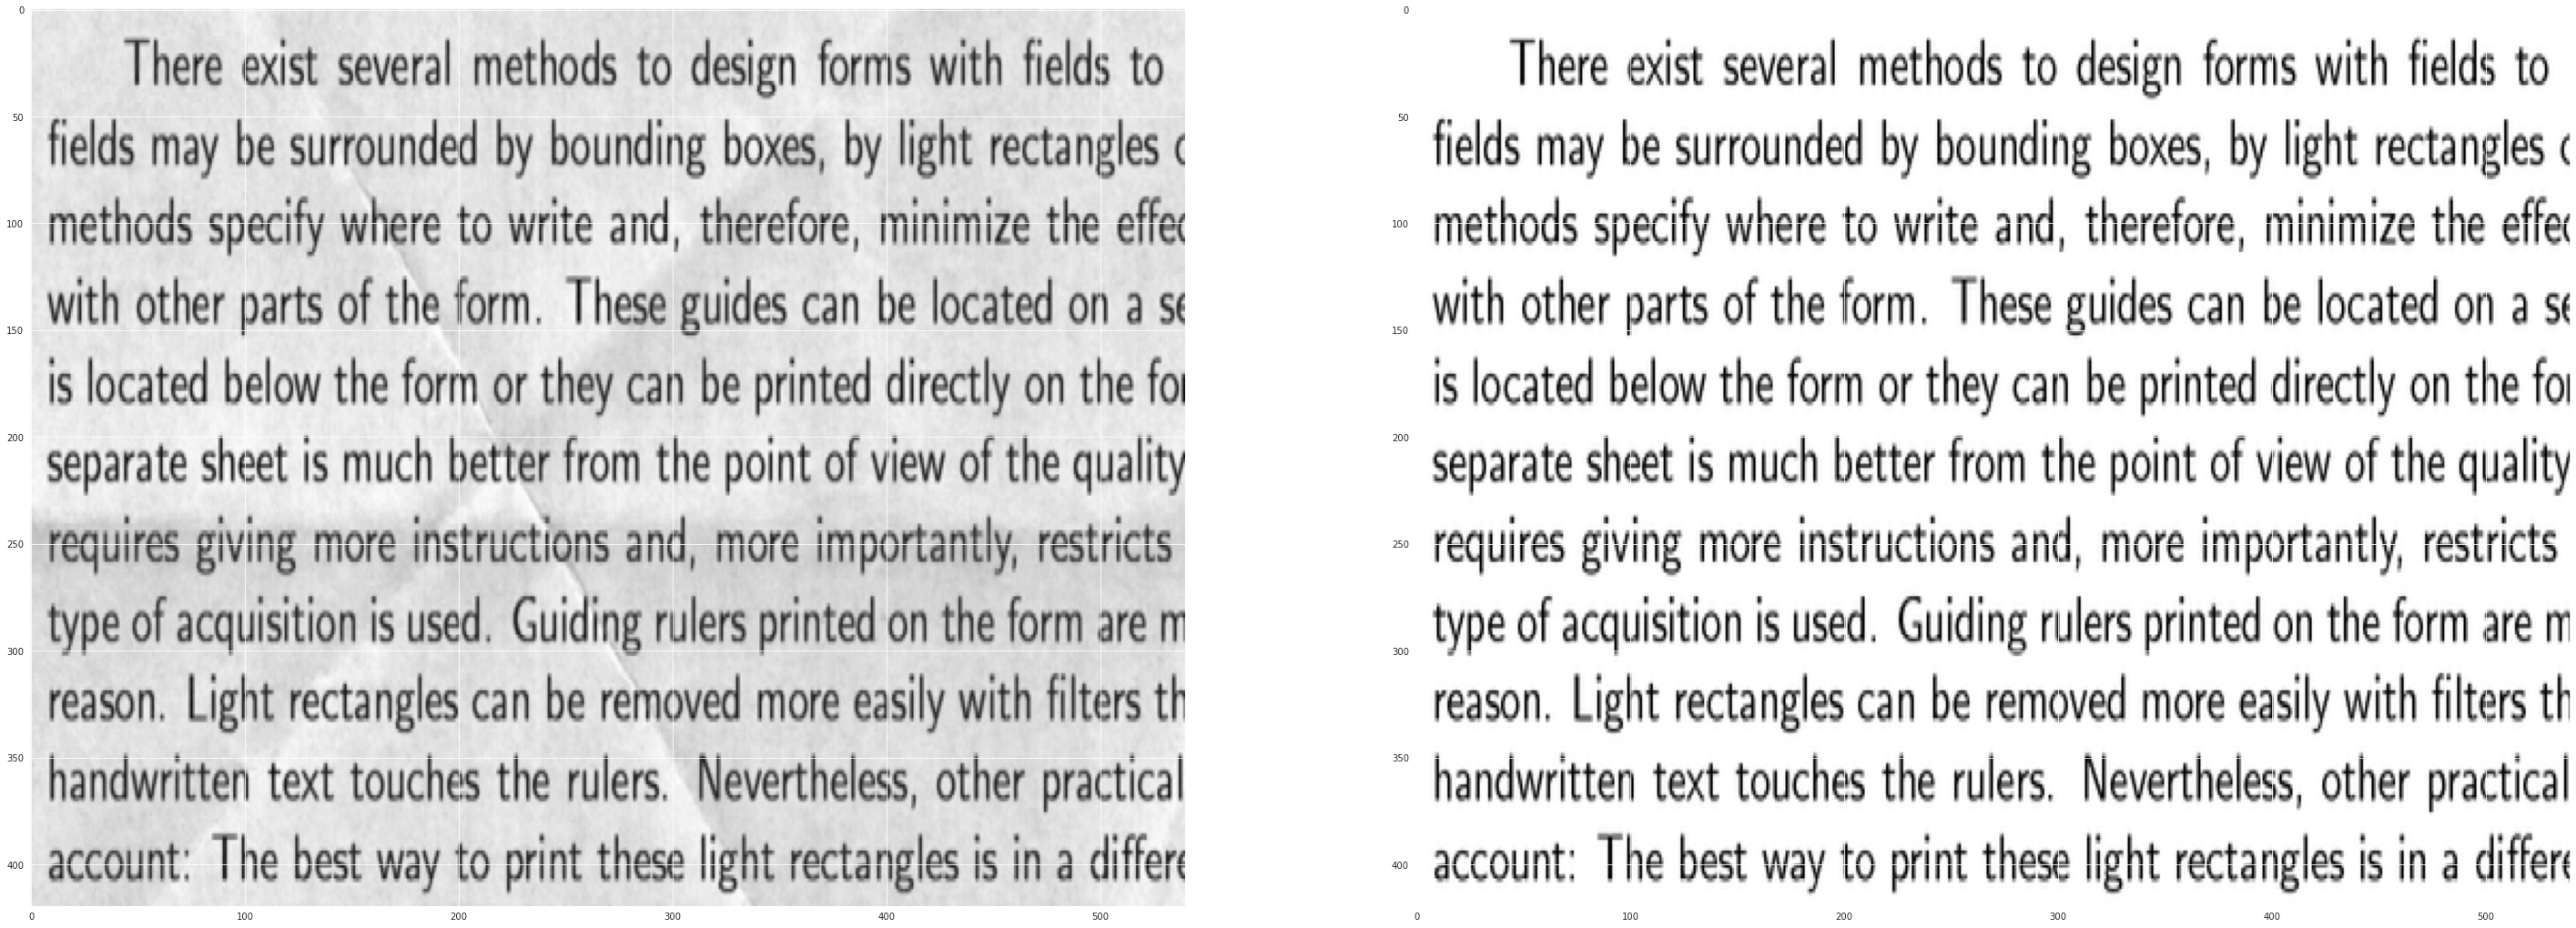

In [11]:
a.see_an_image(100)

In [13]:
"""
train_test_x train_test_y
train_set_x  train_set_y
test_set_x 
"""


'\ntrain_test_x train_test_y\ntrain_set_x  train_set_y\ntest_set_x \n'

In [14]:
batch_size = 5

from torch.utils.data import Dataset

class Dataset96(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [15]:
training_set = Dataset96(train_set_x, train_set_y)
train_loader = torch.utils.data.DataLoader(training_set,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_set = Dataset96(train_test_x, train_test_y)
test_loader  = torch.utils.data.DataLoader(test_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)


In [17]:
# veri 3 boyutlu olduğu için Con2d leri conv3dlere çevirmen gerekiyor.
# aynı şekilde convtranspose3d leri de çevirmek lazım 
# max pooling de değişecek
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv3d(1, 16, kernel_size=5)
    self.conv2 = nn.Conv3d(16, 4, kernel_size=5)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2)
    return x

class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.convt1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
    self.convt2 = nn.ConvTranspose2d(16, 16, 5, stride=1)
    self.convt3 = nn.ConvTranspose2d(16, 16, 2, stride=2)
    self.convt4 = nn.ConvTranspose2d(16, 1, 5, stride=1)

  def forward(self, x):
    x = F.relu(self.convt1(x))
    x = F.relu(self.convt2(x))
    x = F.relu(self.convt3(x))
    x = torch.sigmoid(self.convt4(x))
    return x

In [192]:
class AE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [193]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

aemodel = AE().to(device)
print(aemodel)

AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(5, 5), stride=(1, 1))
  )
  (decoder): Decoder(
    (convt1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (convt2): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
    (convt3): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (convt4): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)


In [194]:
def train(n_epoch, 
          optimizer = torch.optim.Adam(aemodel.parameters(), lr=0.001),
          clip = 1):
  aemodel.train()
  all_loss = []
  for e in range(n_epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, _ = data.to(device), target.to(device)
        #Variables in Pytorch are differenciable. 
        #data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        
        optimizer.zero_grad()

        data = data.unsqueeze(1)
        output = aemodel(data)

        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.mse_loss(output, data)
        #dloss/dx for every Variable 
        loss.backward()
        nn.utils.clip_grad_norm_(aemodel.parameters(), clip)
        #to do a one-step update on our parameter.
        optimizer.step()
        print(f"[EPOCH {e}]: {batch_idx * batch_size}/{len(train_loader) * batch_size}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)
    all_loss.append(loss.item())
  return all_loss

In [195]:
losses = train(n_epoch = 200)
plt.plot(losses)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 1, 5, 5], but got 5-dimensional input of size [128, 1, 3, 420, 540] instead